# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.194461,True,5.231419
1,0.630230,False,0.557614
2,-0.045291,False,-0.049267
3,0.875779,True,6.906012
4,0.206598,True,5.509871
...,...,...,...
995,0.947178,False,-0.462942
996,0.724123,False,0.583023
997,0.172512,True,5.357449
998,-0.535098,False,-0.621551


<AxesSubplot: xlabel='v0'>

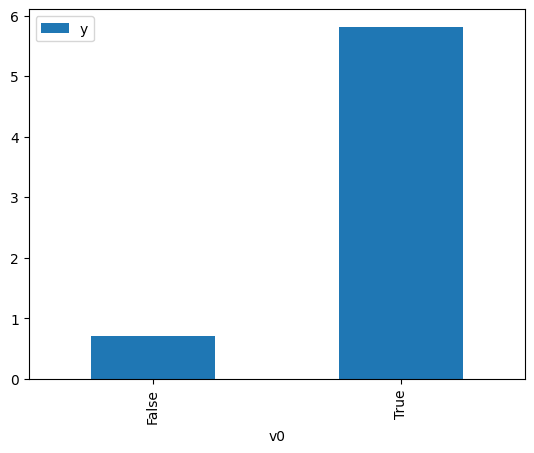

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

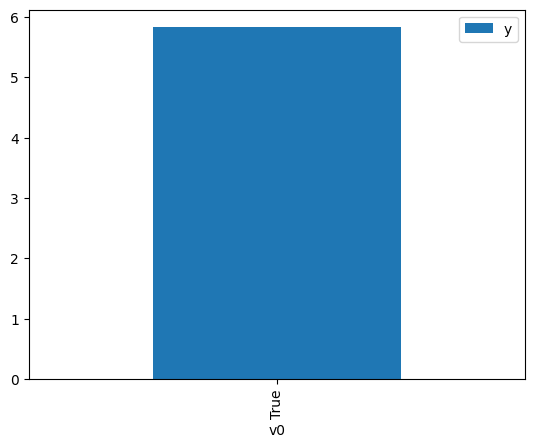

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,2.187329,False,1.990026,0.223009,4.484129
1,1.466404,False,1.339850,0.294147,3.399664
2,-1.335961,False,0.147349,0.639722,1.563179
3,2.804793,False,1.705954,0.172560,5.795095
4,2.638258,False,1.294165,0.185208,5.399343
...,...,...,...,...,...
995,0.209194,False,-1.972994,0.443973,2.252389
996,1.188906,False,0.305349,0.324801,3.078812
997,-1.527157,False,-1.459267,0.662186,1.510149
998,-0.503434,False,0.326277,0.535825,1.866282


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.054966,True,4.881615,0.522091,1.915376
1,0.243468,True,5.172156,0.560399,1.784443
2,1.712749,True,6.118565,0.731598,1.366870
3,0.896934,True,6.339926,0.641246,1.559463
4,0.169593,True,6.711903,0.550965,1.814998
...,...,...,...,...,...
995,1.141826,True,5.418417,0.669836,1.492902
996,-0.797502,True,2.494231,0.426622,2.343996
997,-0.132905,True,4.387969,0.512024,1.953032
998,2.072618,True,7.401623,0.766542,1.304561


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.961
Model:                            OLS   Adj. R-squared (uncentered):              0.961
Method:                 Least Squares   F-statistic:                          1.231e+04
Date:                Thu, 10 Nov 2022   Prob (F-statistic):                        0.00
Time:                        23:43:10   Log-Likelihood:                         -1384.7
No. Observations:                1000   AIC:                                      2773.
Df Residuals:                     998   BIC:                                      2783.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8747      0.029     30.026      0.000       0.818       0.932
x2             5.0545      0.049    103.286      0.000       4.958       5.150
==============================================================================
Omnibus:                        2.125   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.346   Jarque-Bera (JB):                2.152
Skew:                          -0.083   Prob(JB):                        0.341
Kurtosis:                       2.845   Cond. No.                         2.48
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""